# PS4: Gradient descent and regularization
This is a fun but challenging problem set. It will test your python skills, as well as your understanding of the material in class and in the readings. Start early and debug often! Some notes:

* Part 1 is meant to be easy, so get through it quickly.
* Part 2 (especially 2.1) will be difficult, but it is the lynchpin of this problem set so make sure to do it well and understand what you've done. If you find your gradient descent algorithm is taking more than a few minutes to complete, debug more, compare notes with others, and go to the TA sessions (especially the sections on vectorized computation and computational efficiency).
* Depending on how well you've done 2.1, parts 2.3 and 4.3 will be relatively painless or incredibly painful. 
* Part 4 (especially 4.3) will be computationally intensive. Don't leave this until the last minute, otherwise your code might be running when the deadline arrives.
* Do the extra credit problems last.

---

## Introduction to the assignment

As with the last assignment, you will be using a modified version of the [California Housing Prices Dataset](https://inria.github.io/scikit-learn-mooc/python_scripts/datasets_california_housing.html). Please download the csv file from bcourses ('cal_housing_data_clean_ps4.csv'). 

To perform any randomized operation, only use functions in the *numpy library (np.random)*. Do not use other packages for random functions.

In [1]:
import IPython
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib
import sklearn

%matplotlib inline  
import matplotlib.pyplot as plt  
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import statsmodels.formula.api as smf

from sklearn.linear_model import Ridge

In [2]:
# Load the California Housing Dataset 
cal_df = pd.read_csv('cal_housing_data_clean_ps4.csv')

# leave the following line untouched, it will help ensure that your "random" split is the same "random" split used by the rest of the class
np.random.seed(seed=1948)

---

# Part 1: Getting oriented


### 1.1 Use existing libraries

Soon, you will write your own gradient descent algorithm, which you will then use to minimize the squared error cost function.  First, however, let's use the canned versions that come with Python, to make sure we understand what we're aiming to achieve.

Use the [Linear Regression class](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) from sklearn or the [OLS class](http://wiki.scipy.org/Cookbook/OLS) from SciPy to explore the relationship between median housing value and median income in California's census block groups. 

(a) Regress the median housing value `MedHouseVal` on the median income `MedInc`. Draw a scatter plot of housing price (y-axis) against income (x-axis), and draw the regression line in blue.  You might want to make the dots semi-transparent if it improves the presentation of the figure. 

(b) Regress the median housing value on median income and median income squared.  Plot this new (curved) regression line in gold, on the same axes used for part (a). 

(c) Interpret your results.

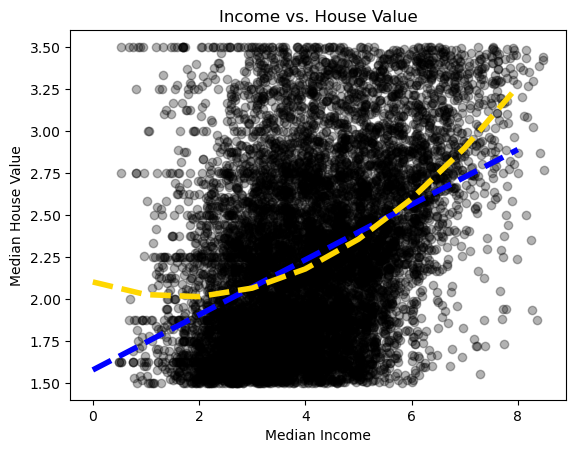

In [3]:
# Your code here
model = LinearRegression()

# a) Regress the median housing value `MedHouseVal` on the median income `MedInc`. Draw a scatter plot of housing price (y-axis) against income (x-axis), and draw the regression line in blue. 
    # (You might want to make the dots semi-transparent if it improves the presentation of the figure)

cal_df['MedInc'].values.shape # (10484,)
cal_df['MedHouseVal'].values.shape # (10484,)

model.fit(cal_df['MedInc'].values.reshape(-1,1), cal_df['MedHouseVal'].values)
intercept = model.intercept_ # 1.577
slope = model.coef_[0] # 0.164

pred = model.predict(cal_df['MedInc'].values.reshape(-1,1))
#plt.scatter(pred, cal_df['MedHouseVal'])

# Scatter Plot
plt.scatter(cal_df['MedInc'], cal_df['MedHouseVal'], alpha = .3, c='black') # Scatter
X_sample = np.arange(0, np.ceil(np.max(cal_df['MedInc'])))
y_sample = intercept + X_sample * slope
plt.plot(X_sample, y_sample, color='blue', lw = 4, ls = 'dashed') # add fit line

plt.title('Income vs. House Value')
plt.xlabel('Median Income')
plt.ylabel('Median House Value')

# b) Regress the median housing value on median income and median income squared.  Plot this new (curved) regression line in gold, on the same axes used for part (a). 
model2 = LinearRegression()

# Set X, Y (let's make this iteration a bit more explicit)
X = np.column_stack((cal_df['MedInc'].values, cal_df['MedInc'].values ** 2))
Y = cal_df['MedHouseVal'].values

# Fit model
model2.fit(X, Y)

# Look at output
coefs = model2.coef_
intercept = model2.intercept_

# Predict
pred2 = model2.predict(X)
pred2

# Plot again
y2_sample = intercept + coefs[0] * X_sample + coefs[1] * X_sample * X_sample
plt.plot(X_sample, y2_sample, color = 'gold', lw = 4, ls = 'dashed')

plt.show()

In [4]:
# c) Interpret your results

# Let's look at error and r2
from sklearn.metrics import mean_squared_error, r2_score
mse_1 = mean_squared_error(cal_df['MedHouseVal'], pred)
r2_1 = r2_score(cal_df['MedHouseVal'], pred)
mse_2 = mean_squared_error(cal_df['MedHouseVal'], pred2)
r2_2 = r2_score(cal_df['MedHouseVal'], pred2)


print(f'Linear Model:\t\tmse: {mse_1: .3f}, r2: {r2_1: .3f}')
print(f'Interaction Model:\tmse: {mse_2: .3f}, r2: {r2_2: .3f}')

Linear Model:		mse:  0.250, r2:  0.161
Interaction Model:	mse:  0.245, r2:  0.179


*Enter your observations here*

Based on R2 and MSE, the Interaction model appears to be a slightly better fit, however it doesn't appear to be a big difference

### 1.2 Training and testing

Chances are, for the above problem you used all of your data to fit the regression line. In some circumstances this is a reasonable thing to do, but if your primary objective is prediction, you should be careful about overfitting. Let's redo the above results the ML way, using careful cross-validation.  Since you are now experts in cross-validation, and have written your own cross-validation algorithm from scratch, you can now take a shortcut and use the libraries that others have built for you.

Using the [cross-validation functions](http://scikit-learn.org/stable/modules/cross_validation.html) from scikit-learn, use 5-fold cross-validation to fit the regression model (a) from 1.1, i.e. the linear fit of median housing value on median income. Each fold of cross-validation will give you one slope coefficient and one intercept coefficient.  Create a new scatterplot of housing price against income, and draw the five different regression lines in light blue, and the original regression line from 1.1 in red (which was estimated using the full dataset). What do you notice?

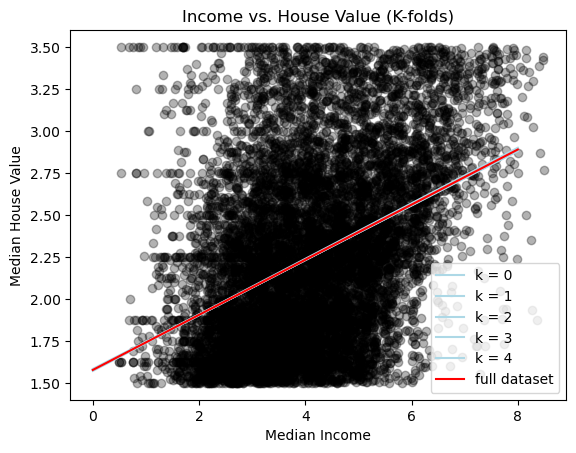

In [5]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

# your code here
k = 5

# a) Linear Model using K-folds
model_kf_1 = LinearRegression()

X = cal_df['MedInc'].values.reshape(-1,1)
y = cal_df['MedHouseVal'].values

# K-folds
kf = KFold(n_splits=k, shuffle=True, random_state=1)

# Store outputs
coefs = []
intercepts = []

# Loop thru KFolds split
for idx_train, idx_test in kf.split(X):
    # Split the data into training and test sets for this fold
    X_train, X_test = X[idx_train], X[idx_test]
    y_train, y_test = y[idx_train], y[idx_test]
    
    # Fit the model on the training data
    model_kf_1.fit(X_train, y_train)
    
    # Store the coefficients and intercept for this fold
    coefs.append(model_kf_1.coef_)
    intercepts.append(model_kf_1.intercept_)


# Now Plot it
plt.scatter(cal_df['MedInc'], cal_df['MedHouseVal'], c='black', alpha = .3)

for i, (a, b) in enumerate(zip(intercepts, coefs)):
    y_kf_sample = a + b * X_sample
    plt.plot(X_sample, y_kf_sample, label = f'k = {i}', c = 'lightblue')

plt.plot(X_sample, y_sample, c='red', label = 'full dataset')

plt.title('Income vs. House Value (K-folds)')
plt.xlabel('Median Income')
plt.ylabel('Median House Value')
plt.legend()

plt.show()

*Enter your observations here*

They all seem about the same, to the point we can't even really see the the k-folds ones

# Part 2: Gradient descent: Linear Regression

This is where it gets fun!

### 2.1 Implement gradient descent with one independent variable (median income)

Implement the batch gradient descent algorithm that we discussed in class. Use the version you implement to regress the median house value on the median income. Experiment with 3-4 different values of the learning rate *R*, and do the following:

* Report the values of alpha and beta that minimize the loss function
* Report the number of iterations it takes for your algorithm to converge (for each value of *R*)
* Report the total running time of your algorithm, in seconds
* How do your coefficients compare to the ones estimated through standard libraries in 1.1? Does this depend on *R*?

Some skeleton code is provided below, but you should feel free to delete this code and start from scratch if you prefer.

* *Hint 1: Don't forget to implement a stopping condition, so that at every iteration you check whether your results have converged. Common approaches to this are to (a) check to see if the loss has stopped decreasing; and (b) check if both your current parameter esimates are close to the estimates from the previous iteration.  In both cases, "close" should not be ==0, it should be <=epsilon, where epsilon is something very small (like 0.0001).*
* *Hint 2: We recommend including a MaxIterations parameter in their gradient descent algorithm, to make sure things don't go off the rails, i.e., as a safeguard in case your algorithm isn't converging as it should. *

In [6]:
import time

"""
Function
--------
bivariate_ols
    Gradient Decent to minimize OLS. Used to find coefficients of bivariate OLS Linear regression

Parameters
----------
x_values, y_values : narray
    x_values: independent variable
    y_values: dependent variable
    
R: float
    Learning rate
    
MaxIterations: Int
    maximum number of iterations

epsilon = .0001: float
    convergence criteria

alpha_init=0, beta_init=1:
    initial values for 
    

Returns
-------
alpha: float
    intercept
    
beta: float
    coefficient
"""
def bivariate_ols(x_values, y_values, R=0.01, MaxIterations=1000, epsilon=.0001, alpha_init=0, beta_init=1):
    start_time = time.time()
    
    # Checks
    assert x_values.shape[0] == np.size(y_values)
    n = np.size(y_values)
    
    # Intialize storage arrays
    cost_storage = np.zeros(MaxIterations)

    # Initialize default params
    alpha = alpha_init
    beta = beta_init

    i = 0
    while(i < MaxIterations):
        # Predict
        y_pred = alpha + beta * x_values

        # Calculate Gradients
        alpha_grad = np.sum(y_pred - y_values) / n
        beta_grad = np.sum((y_pred - y_values) * x_values) / n
        
        # Update params
        alpha = alpha - R * alpha_grad
        beta = beta - R * beta_grad

        # Store costs
        y_pred_new = alpha + beta * x_values
        cost_storage[i] = np.sum((y_pred_new - y)**2)/(2 * n)
        
        # Stop Condition
        if(i > 0 and np.abs(cost_storage[i] - cost_storage[i-1]) < epsilon):
            print(f'breaking at i={i}')
            break
        else:
            i = i + 1

    # if don't converge, find cost-minimizing id?
    lowest_cost_idx = np.argmin(cost_storage)

    print("Time taken: {:.2f} seconds".format(time.time() - start_time))
    #return alpha_storage[lowest_cost_idx], beta_storage[lowest_cost_idx]
    return alpha, beta
    
    #return alpha, beta

for b in range(0,10):
    for a in range(0,10):
        print(bivariate_ols(cal_df['MedInc'].values, cal_df['MedHouseVal'].values, R=.01, MaxIterations=20000, alpha_init=a, beta_init=b, epsilon=.0001))
    

breaking at i=354
Time taken: 0.01 seconds
(0.5190941345063687, 0.3996460640233978)
breaking at i=20
Time taken: 0.00 seconds
(1.071263542055074, 0.2734510580440401)
breaking at i=13
Time taken: 0.00 seconds
(2.008475909564506, 0.06451303150940785)
breaking at i=295
Time taken: 0.01 seconds
(2.6355006781606773, -0.07165005203873467)
breaking at i=861
Time taken: 0.03 seconds
(2.6355592301892234, -0.0716630908113297)
breaking at i=1231
Time taken: 0.05 seconds
(2.6356002116721005, -0.0716722168527173)
breaking at i=1507
Time taken: 0.05 seconds
(2.6350125736100547, -0.07154135752556075)
breaking at i=1726
Time taken: 0.06 seconds
(2.635439211290956, -0.07163636416905148)
breaking at i=1909
Time taken: 0.07 seconds
(2.63487626622666, -0.07151100365022553)
breaking at i=2065
Time taken: 0.07 seconds
(2.6349851378840534, -0.07153524794744372)
breaking at i=501
Time taken: 0.02 seconds
(0.5196695026095898, 0.3995179370559363)
breaking at i=24
Time taken: 0.00 seconds
(0.8671823769778546, 0.

*Enter your observations here*

### 2.2 Data normalization (done for you!)

Soon, you will implement a version of gradient descent that can use an arbitrary number of independent variables. Before doing this, we want to give you some code to standardize your features. 

**For all the following questions, unless explicitly asked otherwise, you are expected to standardize appropriately. Recall that in settings where you are using holdout data for validation or testing purposes, this involves substracting the average and dividing by the standard deviation of your training data.**

In [7]:
'''
Function
--------
standardize
    Column-wise standardization of a target dataframe using the mean and std of a reference dataframe

Parameters
----------
ref,tar : pd.DataFrame
    ref: reference dataframe
    tar: target dataframe
    
Returns
-------
tar_norm: pd.DataFrame
    Standardized target dataframe
'''
def standardize(ref,tar):
    tar_norm = ((tar - np.mean(ref, axis = 0)) / np.std(ref, axis = 0))
    return tar_norm

# Examples
# Standardize train: standardize(ref=x_train,tar=x_train)
# Standardize test: standardize(ref=x_train,tar=x_test)

### 2.3 Implement gradient descent with an arbitrary number of independent variables

Now that you have a simple version of gradient descent working, create a version of gradient descent that can take more than one independent variable.  Assume all independent variables will be continuous.  Test your algorithm using `MedInc`, `HouseAge` and `AveRooms` as independent variables. Remember to standardize appropriately before inputting them to the gradient descent algorithm. How do your coefficients compare to the ones estimated through standard libraries?

As before,  report and interpret your estimated coefficients, the number of iterations before convergence, and the total running time of your algorithm. Experiment with three values of R (0.1, 0.01, and 0.001).

* *Hint 1: Be careful to implement this efficiently, otherwise it might take a long time for your code to run. Commands like `np.dot` can be a good friend to you on this problem*

In [42]:
"""
Function
--------
multivariate_ols
    Gradient Decent to minimize OLS. Used to find coefficients of bivariate OLS Linear regression

Parameters
----------
xvalue_matrix, yvalues : narray
    xvalue_matrix: independent variable
    yvalues: dependent variable
    
R: float
    Learning rate
    
MaxIterations: Int
    maximum number of iterations
    

Returns
-------
beta: array[float]
    coefficients including intercept as first value
"""

def multivariate_ols(xvalue_matrix, yvalues, R=0.01, MaxIterations=1000, epsilon=.0001, beta_init_value=0):
    start_time = time.time()
    # your code here

    # Get Size
    assert xvalue_matrix.shape[0] == np.size(yvalues)
    n = np.size(yvalues)
    n_betas = xvalue_matrix.shape[1] + 1

    # Add Intercept
    xvalue_matrix = np.column_stack((np.ones(n), xvalue_matrix))

    # Initialize betas
    beta = np.repeat(beta_init_value, n_betas)

    # Store values
    cost_storage = np.zeros(MaxIterations)
    beta_storage = np.zeros((MaxIterations, n_betas))

    # Run
    i = 0
    while(i < MaxIterations):
        # Predict
        y_hat = np.dot(xvalue_matrix, beta)
        
        # Calculate Gradient
        gradient = np.dot(xvalue_matrix.T, y_hat - yvalues)/n

        # Update
        beta = beta - R * gradient
        beta_storage[i] = beta

        # Store Cost
        cost_storage[i] = np.sum(np.dot(xvalue_matrix, beta)**2) /(2*n)

        # Check stop condition
        if(i > 0 and np.abs(cost_storage[i] - cost_storage[i-1]) < epsilon):
            print(f"Iterations Required: {i}\nTime taken: {time.time() - start_time:.2f} seconds")
            return beta

        # Update i
        i = i+1
    
    # if it made it through MaxIterations, then choose whichever has the lowest cost
    min_idx = np.argmin(cost_storage,)
    beta = beta_storage[min_idx]
    
    print(f"Iterations Required: {i}\nTime taken: {time.time() - start_time:.2f} seconds")
    return beta


#multivariate_ols(cal_df[['MedInc', 'AveRooms']].values, cal_df['MedHouseVal'].values, MaxIterations=10000, epsilon=.001)
#np.ones(np.size(cal_df['MedHouseVal']))
#cal_df[['MedInc', 'AveRooms']].values

# Set Test Cols
test_cols = ['MedInc', 'HouseAge','AveRooms']
target_col = 'MedHouseVal'

# Separate X, y
X = cal_df[test_cols]
y = cal_df[target_col]

# Normalize Cols
X_norm = standardize(X, X)

output = multivariate_ols(X_norm.values, y.values, R=.01, MaxIterations=10000, epsilon=.0000001)

print(f'output\n\tintrcpt: {output[0]}\n\tcoefs: \t{output[1:]}')

Iterations Required: 1374
Time taken: 0.20 seconds
output
	intrcpt: 2.245870234763479
	coefs: 	[ 0.25444345  0.08669804 -0.03084263]


In [9]:
# Now lets redo it with the sm
X_norm2 = X_norm
X_norm2 = sm.add_constant(X_norm2)

est = sm.OLS(y.values, X_norm2.values).fit()

est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.188
Model:                            OLS   Adj. R-squared:                  0.188
Method:                 Least Squares   F-statistic:                     809.2
Date:                Fri, 08 Mar 2024   Prob (F-statistic):               0.00
Time:                        14:17:56   Log-Likelihood:                -7436.9
No. Observations:               10484   AIC:                         1.488e+04
Df Residuals:                   10480   BIC:                         1.491e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.2459      0.005    467.446      0.000       2.236       2.255
x1             0.2545      0.005     47.713      0.000       0.244       0.265
x2             0.0867      0.005     17.276      0.000       0.077       0.097
x3            -0.0309      0.005     -5.922      0.000      -0.041      -0.021
==============================================================================
Omnibus:                      587.391   Durbin-Watson:                   2.027
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              691.299
Skew:                           0.629   Prob(JB):                    7.70e-151
Kurtosis:                       2.954   Cond. No.                         1.61
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

*Enter your observations here*

After a lot of fiddling with the parameters in my implementation, I was able to get the values to line up almost exactly.

### 2.4 Compare standardized vs. non-standardized results

Repeat the analysis from 2.3, but this time do not standardize your variables - i.e., use the original data. Use the same three values of R (0.1, 0.01, and 0.001). What do you notice about the running time and convergence properties of your algorithm? Compare to the results you would obtain using standard libraries. 

In [10]:
# Your code here

# Add Intercept
X2 = X
X2 = sm.add_constant(X2)
sm_model_nonnorm = sm.OLS(y.values, X2.values).fit()

#display(sm_model_nonnorm.summary())

coefs__sm = sm_model_nonnorm.params

# R = .1 - go down to a more reasonable epsilon and MaxIterations
coefs__gd_R1 = multivariate_ols(X.values, y.values, R=.1, MaxIterations=10000, epsilon=.00001)
# goes to inf

# R = .01
coefs__gd_R01 = multivariate_ols(X.values, y.values, R=.01, MaxIterations=10000, epsilon=.00001)

# R = .001
coefs__gd_R001 = multivariate_ols(X.values, y.values, R=.001, MaxIterations=10000, epsilon=.00001)

print(coefs__sm)
print(coefs__gd_R1)
print(coefs__gd_R01)
print(coefs__gd_R001)


/Users/jon/anaconda3/envs/aml/lib/python3.12/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/var/folders/t8/dm9l8xy95mv0d_75b2m8r5nw0000gn/T/ipykernel_77025/144152375.py:59: RuntimeWarning: overflow encountered in square
  cost_storage[i] = np.sum(np.dot(xvalue_matrix, beta)**2) /(2*n)
/var/folders/t8/dm9l8xy95mv0d_75b2m8r5nw0000gn/T/ipykernel_77025/144152375.py:62: RuntimeWarning: invalid value encountered in scalar subtract
  if(i > 0 and np.abs(cost_storage[i] - cost_storage[i-1]) < epsilon):
/var/folders/t8/dm9l8xy95mv0d_75b2m8r5nw0000gn/T/ipykernel_77025/144152375.py:55: RuntimeWarning: invalid value encountered in subtract
  beta = beta - R * gradient


Iterations Required: 10000
Time taken: 1.24 seconds
Iterations Required: 10000
Time taken: 1.21 seconds
Iterations Required: 1736
Time taken: 0.23 seconds
[ 1.34200301  0.19077902  0.00698801 -0.01350345]
[-inf -inf  nan -inf]
[-inf -inf  nan -inf]
[0.12905922 0.31453696 0.02185527 0.03016742]


*Enter your observations here*

They take much longer to converge and are much less likely to do so in a standard amount of time. When it did converge, the results are fairly different which suggests it needs many more iterations to find the convergence point, and that the function does not follow as much of a linear relationship as the standardized versions

# 3. Prediction

Let's use our fitted model to make predictions about housing prices. 

### 3.1 Cross-Validation

Unless you were careful above, you probably overfit your data again. Let's fix that. Use 5-fold cross-validation to re-fit the multivariate regression from 2.3 above, and report your estimated coefficients (there should be four, corresponding to the intercept and the three coefficients for `MedInc` and `AveRoomsNorm`, `HouseAgeNorm`). Since there are 5 folds, there will be 5 sets of four coefficients -- report them all in a 5x4 table.

**Note:** You can use KFold to perform the cross-validation. 

In [43]:
def compute_rmse(predictions, yvalues):
    P = np.array(predictions)
    Y = np.array(yvalues)
    rmse = ((P-Y)**2).sum()*1.0 / len(P) 
    rmse = np.sqrt(rmse)
    return rmse

# Your code here
K = 5

kf = KFold(n_splits=K)

# Instantiate Model
models_kf = LinearRegression()

# create storage
coefs__LR = np.zeros((K, X_norm.shape[1] + 1)) # For the built-in Linear Regression
coefs__GD = np.zeros((K, X_norm.shape[1] + 1)) # For my implementation of Gradient Descent

i = 0
for idx_train, idx_test in kf.split(X_norm.values):
    # Split the data into training and test sets for this fold
    X_train, X_test = X_norm.values[idx_train], X_norm.values[idx_test]
    y_train, y_test = y.values[idx_train], y.values[idx_test]
    
    # Linear Regression
    # Fit the model on the training data
    models_kf.fit(X_train, y_train)
    
    # Store the coefficients and intercept for this fold
    LR_coefs = np.append(models_kf.intercept_, models_kf.coef_)
    coefs__LR[i] = LR_coefs

    # Gradient Descent
    GD_coefs = multivariate_ols(X_train, y_train, R=.01, MaxIterations=10000, epsilon=.0000001)
    coefs__GD[i] = GD_coefs

    i=i+1
    
display(pd.DataFrame(coefs__GD).rename(columns = lambda x: f'b{x}'))

Iterations Required: 1382
Time taken: 0.20 seconds
Iterations Required: 1507
Time taken: 0.21 seconds
Iterations Required: 1360
Time taken: 0.19 seconds
Iterations Required: 1363
Time taken: 0.19 seconds
Iterations Required: 1369
Time taken: 0.19 seconds


,b0,b1,b2,b3
0,2.247110,0.252201,0.087007,-0.030311
1,2.246911,0.260782,0.086502,-0.052491
2,2.247057,0.253123,0.084969,-0.027762
3,2.246057,0.253713,0.086914,-0.028335
4,2.242012,0.256149,0.087180,-0.026035


*Discuss your results here*

### 3.2 Predicted values and RMSE

Let's figure out how accurate this predictive model turned out to be. Compute the cross-validated RMSE for each of the 5 folds above. In other words, in fold 1, use the parameters estimated on the 80% of the data to make predictions for the 20%, and calculate the RMSE for those 20%. Repeate this for the remaining folds. Report the RMSE for each of the 5-folds, and the average (mean) RMSE across the five folds. How does this average RMSE compare to the performance of your nearest neighbor algorithm from the last problem set?

In [45]:
# Your code here
rmse_save = []

for i, idxs in enumerate(kf.split(X_norm.values)):
    # Get idx
    idx_train, idx_test = idxs

    # Set X/y
    X_train, X_test = X_norm.values[idx_train], X_norm.values[idx_test]
    y_train, y_test = y.values[idx_train], y.values[idx_test]
    
    assert X_test.shape[0] == np.size(y_test)
    n = np.size(y_test)

    # Get Coefs
    beta = coefs__GD[i]

    # Add Intercept
    X_test = np.column_stack((np.ones(n), X_test))

    # Predict
    y_hat = np.dot(X_test, beta)

    # Calculate Error
    err = compute_rmse(y_hat, y_test)

    rmse_save.append(err)

rmse_save

[0.4812479053332355,
 0.49877227651856076,
 0.4880438908463683,
 0.49200196661073703,
 0.5025827423080966]

*Discuss your results here*

TODO: compare to last PSet

## 4 Regularization 

### 4.1 Get prepped

Step 1: Generate features consisting of all polynomial combinations of degree greater than 0 and less than or equal to 3 of the following features: `MedInc`, `HouseAge` and `AveRooms`. If you are using PolynomialFeatures of sklearn.preprocessing make sure you drop the constant polynomial feature (degree 0). You should have a total of 19 polynomial features. 

Step 2: Randomly sample 80% of your data and call this the training set, and set aside the remaining 20% as your test set.

In [46]:
from sklearn.preprocessing import PolynomialFeatures
# Your code here

# Degree > 0, <= 3, means MedInc, HouseAge, AveRooms, MedInc * HouseAge, MedInc * AveRooms, HouseAge * AveRooms, MedInc * HouseAge * AveRooms (and self-iteractions)
pf = PolynomialFeatures(degree=(1,3), include_bias=False)

X_pf = pf.fit_transform(X)
X_pf_norm = standardize(X_pf, X_pf)
X_pf_norm__df = pd.DataFrame(X_pf_norm, columns=pf.get_feature_names_out())


In [47]:
X_pf_norm__df

,MedInc,HouseAge,AveRooms,MedInc^2,MedInc HouseAge,MedInc AveRooms,HouseAge^2,HouseAge AveRooms,AveRooms^2,MedInc^3,MedInc^2 HouseAge,MedInc^2 AveRooms,MedInc HouseAge^2,MedInc HouseAge AveRooms,MedInc AveRooms^2,HouseAge^3,HouseAge^2 AveRooms,HouseAge AveRooms^2,AveRooms^3
0,-0.291055,1.661057,-0.073082,-0.410117,1.267123,-0.272965,1.967254,1.308750,-0.038158,-0.465928,0.554182,-0.396751,1.795269,0.810113,-0.061528,2.140515,1.883314,0.072832,-0.015695
1,-0.685003,-0.192469,-0.474264,-0.718115,-0.526538,-0.671604,-0.387511,-0.436330,-0.085495,-0.681282,-0.657948,-0.689753,-0.525315,-0.615262,-0.111462,-0.485569,-0.490536,-0.069069,-0.018384
2,-0.953982,0.532824,-0.637052,-0.901268,-0.236835,-0.854052,0.361919,-0.126848,-0.102082,-0.792732,-0.612910,-0.816694,-0.077303,-0.539009,-0.129553,0.178319,-0.022209,-0.059390,-0.019196
3,0.115263,0.291059,0.236207,-0.042952,0.441107,0.138137,0.087537,0.509878,0.004609,-0.169324,0.274089,-0.029401,0.232511,0.471016,-0.004193,-0.086906,0.290990,0.038135,-0.012852
4,0.516933,0.774588,0.093750,0.369412,1.274096,0.251809,0.660871,0.790034,-0.015767,0.208990,1.140446,0.191592,1.113539,0.982965,-0.003219,0.493141,0.788467,0.049312,-0.014252
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10479,-0.473373,0.694000,-0.226107,-0.558531,0.297249,-0.447726,0.558490,0.392144,-0.057298,-0.573806,-0.124007,-0.535109,0.365359,0.030108,-0.083900,0.382427,0.436318,-0.003238,-0.016844
10480,1.554543,-0.756586,0.156908,1.661969,0.103886,0.860622,-0.817511,-0.466204,-0.006876,1.653867,0.709451,1.134069,-0.496953,0.154149,0.060351,-0.766801,-0.694866,-0.044490,-0.013651
10481,0.731562,0.613412,0.322241,0.609890,1.288194,0.551769,0.458839,0.883649,0.017476,0.449553,1.306722,0.496594,0.998038,1.224554,0.044414,0.277539,0.752061,0.075760,-0.011929
10482,0.698202,-1.240114,-0.277178,0.571592,-0.838526,0.046201,-1.079607,-1.041403,-0.063388,0.410309,-0.461352,0.106174,-0.971552,-0.721706,-0.046714,-0.889140,-1.008653,-0.100031,-0.017193


### 4.2 Complexity and overfitting?

Now, using your version of multivariate regression from 2.3, let's try to build a more complex model. **Remember to standardize appropriately!** Using the training set, regress the median house value on the polynomial features using your multivariate ols algorithm. Calculate train and test RMSE. Is this the result that you were expecting? How do these numbers compare to each other, and to the RMSE from 3.2 and nearest neighbors?

In [64]:
# Your code here
# X_pf_norm__df = pd.DataFrame(X_pf_norm, columns=pf.get_feature_names_out())

coefs = multivariate_ols(X_pf_norm, y.values, MaxIterations=10000, beta_init_value=0, epsilon=.0000001)

# Add intercept
X_pf_norm__plus_int = np.column_stack((np.ones(X_pf_norm.shape[0]), X_pf_norm))

y_hat = np.dot(X_pf_norm__plus_int, coefs)

compute_rmse(y_hat, y.values) # .4835



Iterations Required: 2197
Time taken: 0.52 seconds


0.4834745321614672

*Discuss your results here*

### 4.3 Ridge regularization (basic)
Incorporate L2 (Ridge) regularization into your multivariate_ols regression. Write a new version of your gradient descent algorithm that includes a regularization term "lambda" to penalize excessive complexity. 

Use your regularized regression to re-fit the model using all the polynomial features on your training data and using the value lambda = 10^4.  Report the RMSE obtained for your training data, and the RMSE obtained for your testing data.

In [76]:
def multivariate_regularized_ols(xvalue_matrix, yvalues, R=0.01, MaxIterations=1000, epsilon=.001, beta_init_value=0, lmbda=0, add_intercept=True):
    start_time = time.time()
    # Your code here

    # Get Size
    assert xvalue_matrix.shape[0] == np.size(yvalues)
    n = np.size(yvalues)
    n_betas = xvalue_matrix.shape[1]

    # Add Intercept
    if(add_intercept):
        xvalue_matrix = np.column_stack((np.ones(n), xvalue_matrix))
        n_betas = n_betas + 1

    # Initialize betas
    beta = np.repeat(beta_init_value, n_betas)

    # Store values
    cost_storage = np.zeros(MaxIterations)
    beta_storage = np.zeros((MaxIterations, n_betas))

    # Run
    i = 1
    while(i < MaxIterations):
        # Predict
        y_hat = np.dot(xvalue_matrix, beta)
        
        # Calculate Gradient
        gradient = (np.dot(xvalue_matrix.T, y_hat - yvalues))/n

        # Update
        beta = beta - R * gradient
        beta_storage[i] = beta

        # Store Cost
        cost_storage[i] = (np.sum(np.dot(xvalue_matrix, beta)**2) + (lmbda * np.sum(beta[1:]**2))) / (2*n) 

        # Check stop condition
        if(i > 0 and np.abs(cost_storage[i] - cost_storage[i-1]) < epsilon):
            print(f"Iterations Required: {i}\nTime taken: {time.time() - start_time:.2f} seconds")
            return beta

        # Update i
        i = i+1
    
    # if it made it through MaxIterations, then choose whichever has the lowest cost
    min_idx = np.argmin(cost_storage)
    beta = beta_storage[min_idx]

    print("\nMax iterations required -- Time taken: {:.2f} seconds".format(time.time() - start_time))
    return beta[0], beta[1:]

# Run it
coefs_ridge = multivariate_regularized_ols(X_pf_norm, y.values, MaxIterations=10000, epsilon=.00001, add_intercept=True, lmbda=10000)
coefs_ridge

# Predict
y_hat_ridge = np.dot(X_pf_norm__plus_int, coefs_ridge)

# Compute RMSE
compute_rmse(y_hat_ridge, y.values) # .4839

Iterations Required: 910
Time taken: 0.21 seconds


0.483892599793262

*Discuss your results here*

### 4.4: Cross-validate lambda

This is where it all comes together! Use k-fold cross-validation to select the optimal value of lambda in a regression using all the polynomial features. In other words, define a set of different values of lambda. Then, using the 80% of your data that you set aside for training, iterate through the values of lambda one at a time. For each value of lambda, use k-fold cross-validation to compute the average cross-validated RMSE for that lambda value, computed as the average across the held-out folds. You should also record the average cross-validated train RMSE, computed as the average across the folds used for training. Create a scatter plot that shows RMSE as a function of lambda. The scatter plot should have two lines: a gold line showing the cross-validated RMSE, and a blue line showing the cross-validated train RMSE.  At this point, you should not have touched your held-out 20% of "true" test data.

What value of lambda minimizes your cross-validated RMSE? Fix that value of lambda, and train a new model using all of your training data with that value of lambda (i.e., use the entire 80% of the data that you set aside in 4.1). Calculate the RMSE for this model on the 20% of "true" test data. How does your test RMSE compare to the RMSE from 3.2, 4.2, 4.3 and to the RMSE from nearest neighbors? What do you make of these results? 

Go brag to your friends about how you just implemented cross-validated ridge-regularized multivariate regression using gradient descent optimization, from scratch!

In [ ]:
# Your code here

# Set of possible lambdas
lmbdas = np

k = 5

# a) Linear Model using K-folds
model_kf_2 = LinearRegression()


X_pf_norm__plus_int
X = cal_df['MedInc'].values.reshape(-1,1)
y = cal_df['MedHouseVal'].values

# K-folds
kf2 = KFold(n_splits=k, shuffle=True, random_state=1)

# # Store outputs
# coefs = []
# intercepts = []

# # Loop thru KFolds split
# for idx_train, idx_test in kf.split(X):
#     # Split the data into training and test sets for this fold
#     X_train, X_test = X[idx_train], X[idx_test]
#     y_train, y_test = y[idx_train], y[idx_test]
    
#     # Fit the model on the training data
#     model_kf_1.fit(X_train, y_train)
    
#     # Store the coefficients and intercept for this fold
#     coefs.append(model_kf_1.coef_)
#     intercepts.append(model_kf_1.intercept_)


# # Now Plot it
# plt.scatter(cal_df['MedInc'], cal_df['MedHouseVal'], c='black', alpha = .3)

# for i, (a, b) in enumerate(zip(intercepts, coefs)):
#     y_kf_sample = a + b * X_sample
#     plt.plot(X_sample, y_kf_sample, label = f'k = {i}', c = 'lightblue')

# plt.plot(X_sample, y_sample, c='red', label = 'full dataset')

# plt.title('Income vs. House Value (K-folds)')
# plt.xlabel('Median Income')
# plt.ylabel('Median House Value')
# plt.legend()

# plt.show()



*Discuss your results here*

### 4.5: Compare your results to sklearn ridge [extra-credit]

Repeat your analysis in 4.4, but this time use the sklearn implementation of ridge regression (sklearn.linearmodel.Ridge). Are the results similar? How would you explain the differences, if any?

In [ ]:
# Your code here

*Discuss your results here*

### 4.6: AdaGrad [extra-credit]

AdaGrad is a method to implement gradient descent with different learning rates for each feature. Adaptive algorithms like this one are being extensively used especially in neural network training. Implement AdaGrad on 2.3 using `MedInc`, `HouseAge` and `AveRooms` as independent variables. Standardize these variables before inputting them to the gradient descent algorithm. Tune the algorithm until you estimate the regression coefficients within a tolerance of 1e-1. Use mini-batch gradient descent in this implementation. In summary for each parameter (in our case one intercept and three slopes) the update step of the gradient (in this example $\beta_j$) at iteration $k$ of the GD algorithm becomes:

$$\beta_j=\beta_j -\frac{R}{\sqrt{G^{(k)}_j}}\frac{\partial J(\alpha,\beta_1,\ldots)}{\partial \beta_j}$$ where
$G^{(k)}_j=\sum_{i=1}^{k} (\frac{\partial J^{(i)}(\alpha,\beta_1,\ldots)}{\partial \beta_j})^2$ and $R$ is your learning rate. The notation $\frac{\partial J^{(i)}(\alpha,\beta_1,\ldots)}{\partial \beta_j}$ corresponds to the value of the gradient at iteration $(i)$. Essentially we are "storing" information about previous iteration gradients. Doing that we effectively decrease the learning rate slower when a feature $x_i$ is sparse (i.e. has many zero values which would lead to zero gradients). Although this method is not necessary for our regression problem, it is good to be familiar with these methods as they are widely used in neural network training.  

In [ ]:
# Your code here

*Discuss your results here*